In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import tqdm
from time import sleep
import time
from PIL import Image
from io import BytesIO
from adjustText import adjust_text


from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name, get_teams, find_team_name_by_id
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats
from collections import Counter

In [2]:
import json

In [3]:
full_df = pd.read_csv('pbp_data/2022-23.csv')

full_df = full_df.fillna({
    "HOMEDESCRIPTION": "",
    "NEUTRALDESCRIPTION": "",
    "VISITORDESCRIPTION": ""
})
full_df.loc[:, 'GAME_ID'] = [f"00{item}" for item in full_df.GAME_ID.astype(str)]

In [5]:
season = '2022-23'

In [6]:
shots = ShotChartDetail(team_id=0, player_id=0, context_measure_simple='FGM', season_nullable=season)

shots_df = shots.get_data_frames()[0]

In [8]:
league_stats = LeagueDashPlayerStats(per_mode_detailed='PerGame', season=season, season_type_all_star='Regular Season', player_position_abbreviation_nullable='C')

In [9]:


league_df = league_stats.get_data_frames()[0]


In [15]:
top_40 = league_df.sort_values(by='MIN', ascending=False).iloc[:40]

In [17]:
player_assists = full_df.loc[(full_df.PLAYER2_ID.isin(top_40.PLAYER_ID.tolist())) & (full_df.EVENTMSGTYPE == 1)]

In [19]:
big_man_score = player_assists.loc[player_assists.PLAYER1_ID.isin(top_40.PLAYER_ID.tolist())]

In [29]:
assists_big_men = big_man_score.groupby(['PLAYER1_ID', 'PLAYER2_ID']).size().reset_index()

In [43]:
assists_big_men = assists_big_men.rename(columns={0: 'COUNT'})

In [44]:
name_only = top_40.loc[:, ['PLAYER_ID', 'PLAYER_NAME']]

In [45]:
merged_df = pd.merge(left=assists_big_men, right=name_only, left_on=['PLAYER1_ID'], right_on='PLAYER_ID')

In [46]:
del merged_df['PLAYER_ID']

In [47]:
merged_df = merged_df.rename(columns={'PLAYER_NAME': 'SCORER_NAME'})

In [48]:
merged_df = pd.merge(left=merged_df, right=name_only, left_on=['PLAYER2_ID'], right_on='PLAYER_ID')

In [49]:
del merged_df['PLAYER_ID']

In [51]:
merged_df = merged_df.rename(columns={'PLAYER_NAME': 'ASSISTER_NAME'})

In [54]:
top_combinations = merged_df.sort_values(by='COUNT', ascending=False).iloc[:10]

In [56]:
plt.style.use('fivethirtyeight')

In [61]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
zoom = 0.63
team_root_dir = '../../team_logos_id/'
player_root_dir = f'player_imgs/'

def get_player_img(player_id, zoom=0.63):
    #print(path)
    return OffsetImage(plt.imread(f'{player_root_dir}{player_id}.png'), zoom=zoom)

def get_team_img(team_id):
    #print(path)
    return OffsetImage(plt.imread(f'{team_root_dir}{team_id}.png'), zoom=zoom)

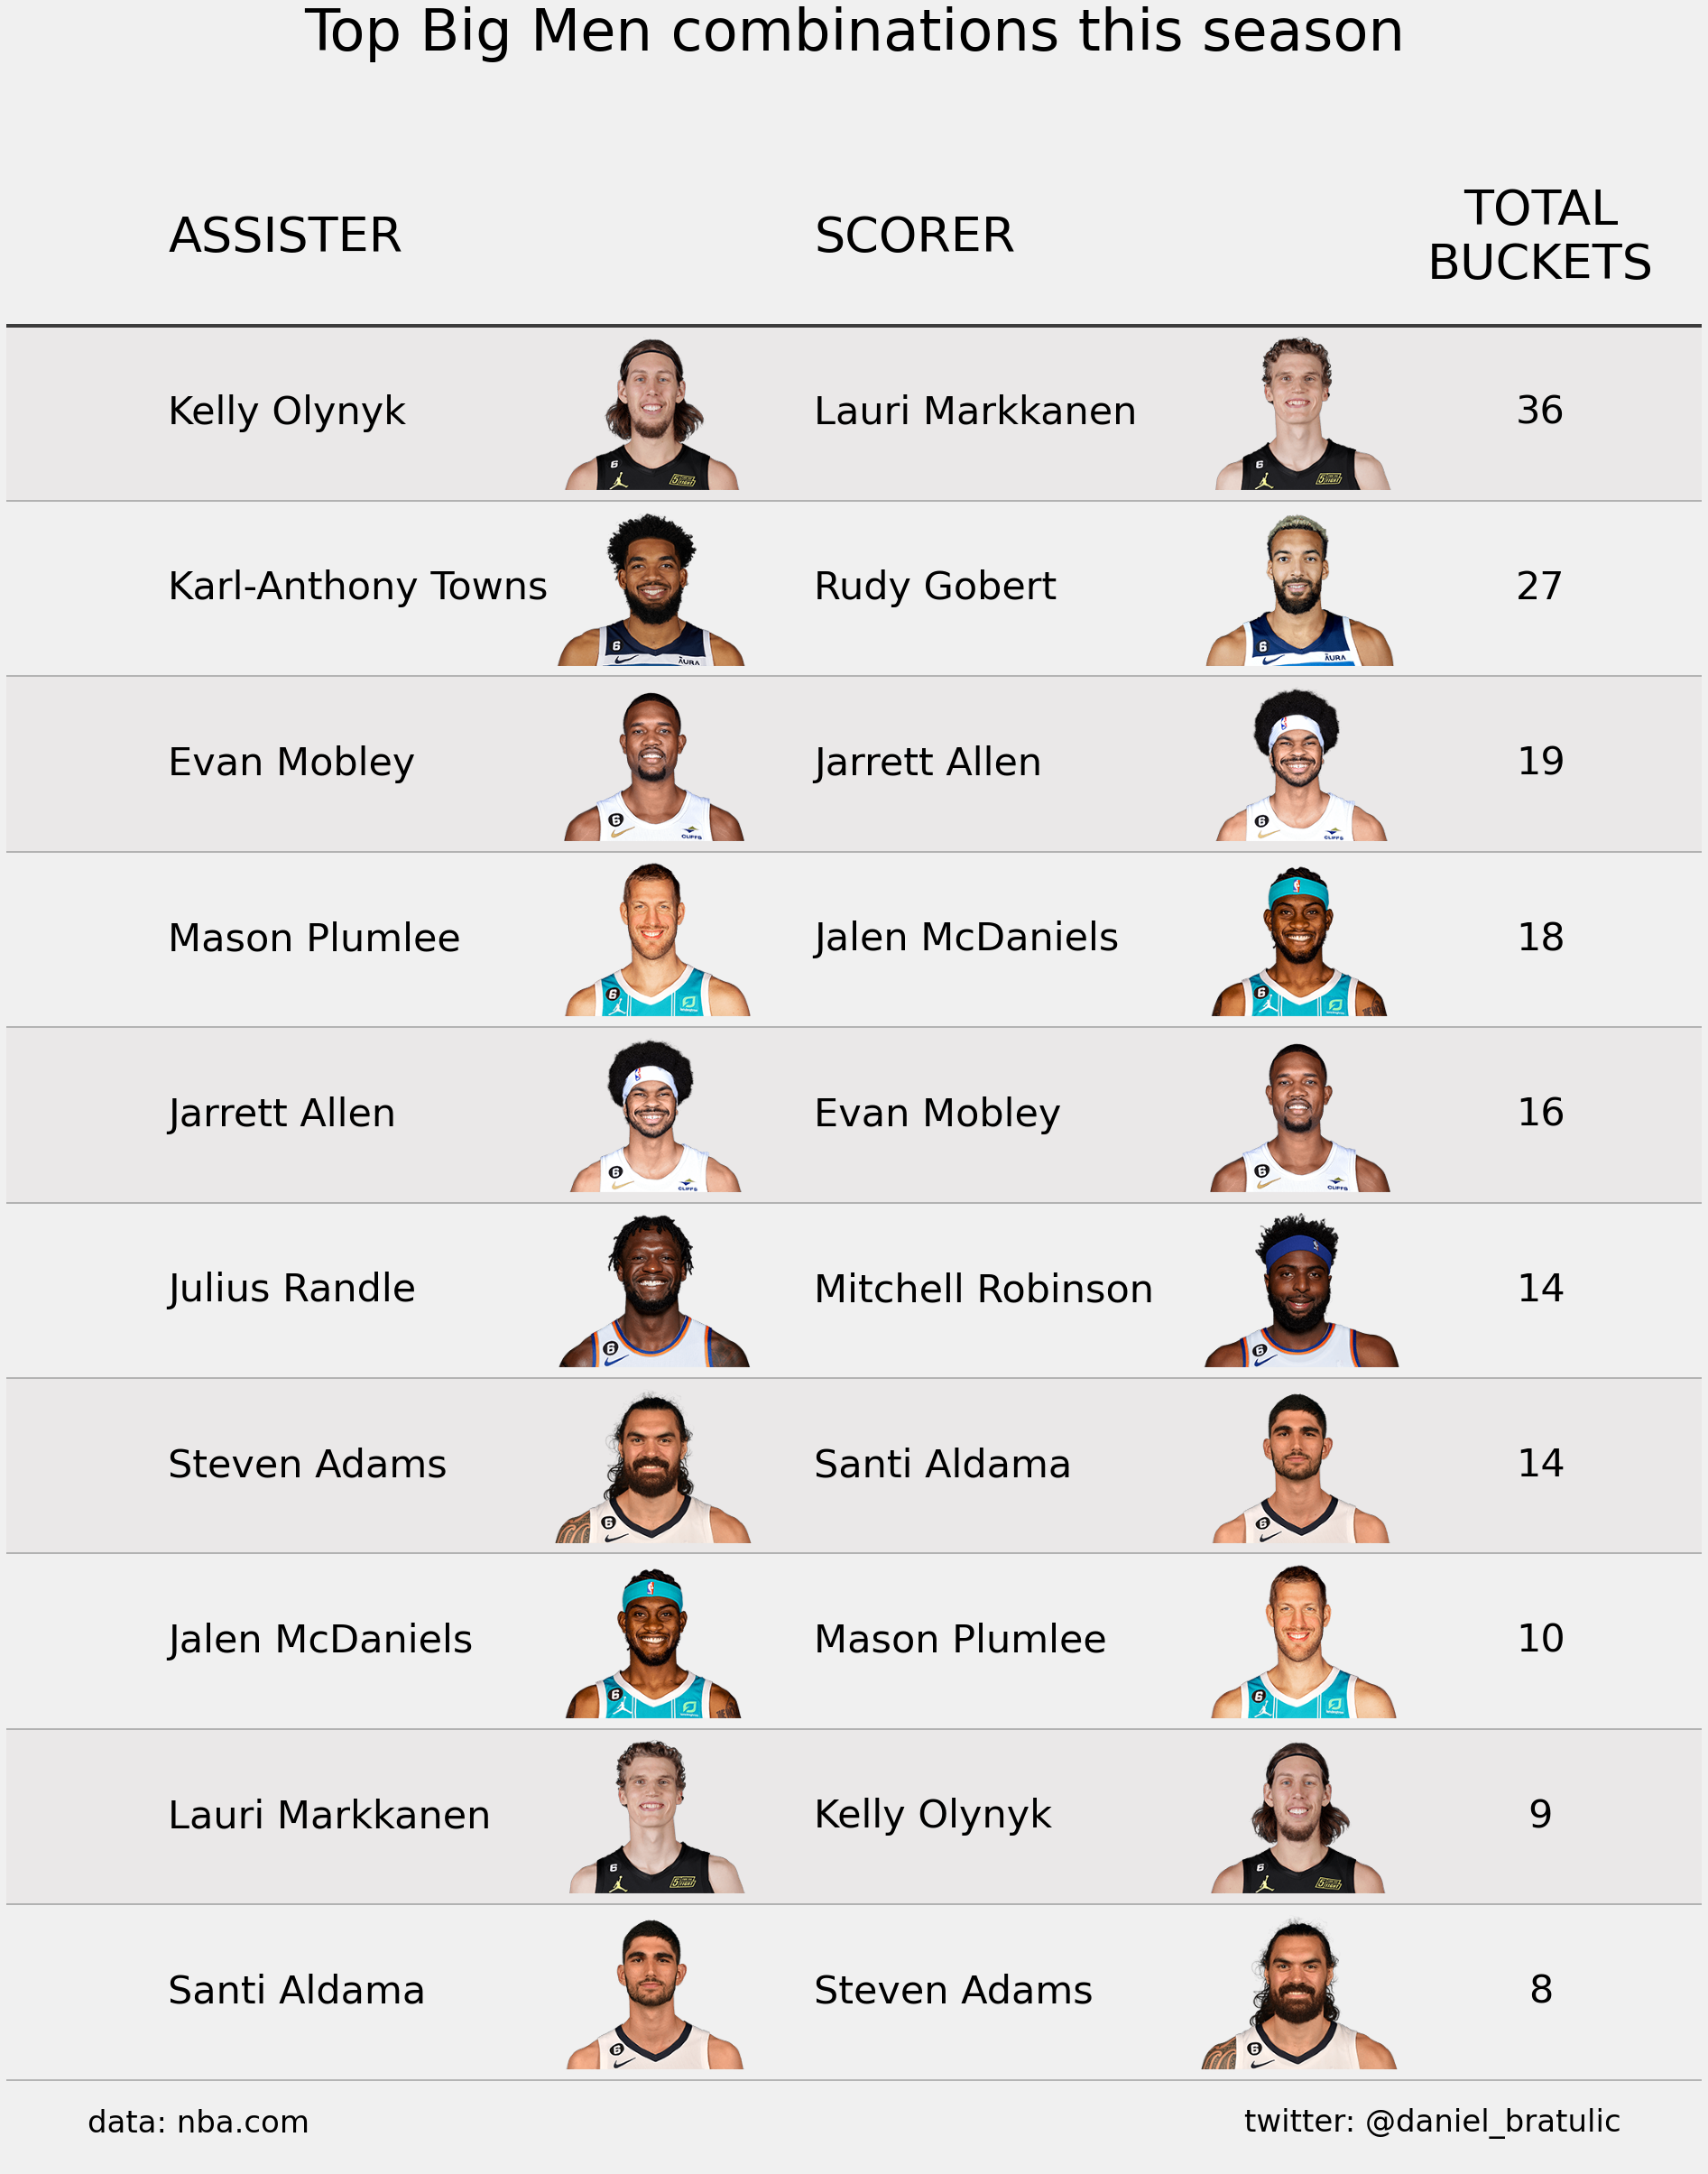

In [65]:
fig, ax = plt.subplots(figsize=(30, 40))
font_size = 38+5
font_title = 44+10
top = len(top_combinations)
#top = 10


for i in range(top):
    item = top_combinations.iloc[i]
    y_coord = top - i - 1
    if i % 2 == 1:
        color = '#EAE8E8'
        rect = Rectangle((-4.5, y_coord + 0.5), width=15, height=1, fill=True, color=color)
        ax.add_patch(rect)
    ax.axhline(y=y_coord-0.5, xmin=-0.25, xmax=10, color='#A0A0A0', alpha=0.75, lw=2)
    ab = AnnotationBbox(get_player_img(item.PLAYER2_ID, 0.9), (0.4, y_coord), frameon=False)
    ax.add_artist(ab)
    ax.text(x=0.1, y=y_coord, ha='left', va='center', s=item.ASSISTER_NAME, size=font_size)
    
    ab = AnnotationBbox(get_player_img(item.PLAYER1_ID, 0.9), (0.8, y_coord), frameon=False)
    ax.add_artist(ab)
    ax.text(x=0.5, y=y_coord, ha='left', va='center', s=item.SCORER_NAME, size=font_size)
    ax.text(x=0.95, y=y_coord, ha='center', va='center', s=f"{item.COUNT}", size=font_size)
    #ax.text(x=2.2, y=y_coord, ha='center', va='center', s=f"{item.OPP_WIDE_OPEN_FG3_PCT:.2f}%", size=font_size)
    #ax.text(x=2.7, y=y_coord, ha='center', va='center', s=f"{item.DIFF:.2f}%", size=font_size)
    

    #ax.imshow(player_imgs[item.PLAYER_ID], extent=(0, 0.3, y_coord-0.5,y_coord + 0.5), aspect='auto', zorder=1)
    #ax.imshow(team_imgs[item.TEAM_ID], extent=(0.27, 0.38, y_coord-0.5,y_coord + 0.5), aspect='auto', zorder=1)
    
    
    #y_img_start = y_coord-0.5 + (1 - 0.730769232) / 2
    #ax.imshow(img, extent=(0, 1.36, y_img_start-0.5, y_img_start + 0.1), aspect='auto')
    #ax.imshow(img, extent=(0, 260, 0, 190), aspect=260/190)
    
ax.text(x=0.1, y=top, s='ASSISTER', ha='left', va='center', size=font_title)
ax.text(x=0.5, y=top, ha='left', va='center', s="SCORER", size=font_title)
ax.text(x=0.95, y=top, ha='center', va='center', s="TOTAL\nBUCKETS", size=font_title)
#ax.text(x=2.7, y=top, ha='center', va='center', s="DIFF", size=font_title)

ax.text(x=1.0, y=-0.75, s='twitter: @daniel_bratulic', ha='right', va='center', size=34)
ax.text(x=0.05, y=-0.75, s='data: nba.com', ha='left', va='center', size=34)
ax.axhline(y=top-0.5, xmin=-0.25, xmax=10, color='black', alpha=0.75, lw=4)
ax.set_title("Top Big Men combinations this season", size=64)
    
ax.set_ylim(bottom=-1, top=top+1)
ax.set_xlim(left=-0, right=1.05)
ax.grid(False)
ax.set_frame_on(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.savefig('table_big_men.png', dpi=120, bbox_inches='tight')

## Full combinations

In [68]:
full_df.loc[full_df.EVENTMSGTYPE == 1].PLAYER2_ID

2          201950
20         201950
33        1626192
40              0
57              0
           ...   
328415          0
328426    1630240
328437          0
328450          0
328463    1626220
Name: PLAYER2_ID, Length: 58172, dtype: int64

In [69]:
player_assists = full_df.loc[(full_df.PLAYER2_ID != 0) & (full_df.EVENTMSGTYPE == 1)]

In [83]:

assists_combo = player_assists.groupby(['PLAYER1_ID', 'PLAYER2_ID', 'PLAYER1_NAME', 'PLAYER2_NAME']).size().reset_index()

In [84]:
assists_combo = assists_combo.rename(columns={0: 'COUNT'})

In [85]:
assists_combo = assists_combo.sort_values(by='COUNT', ascending=False)

In [86]:
top_assists = assists_combo.iloc[:20]

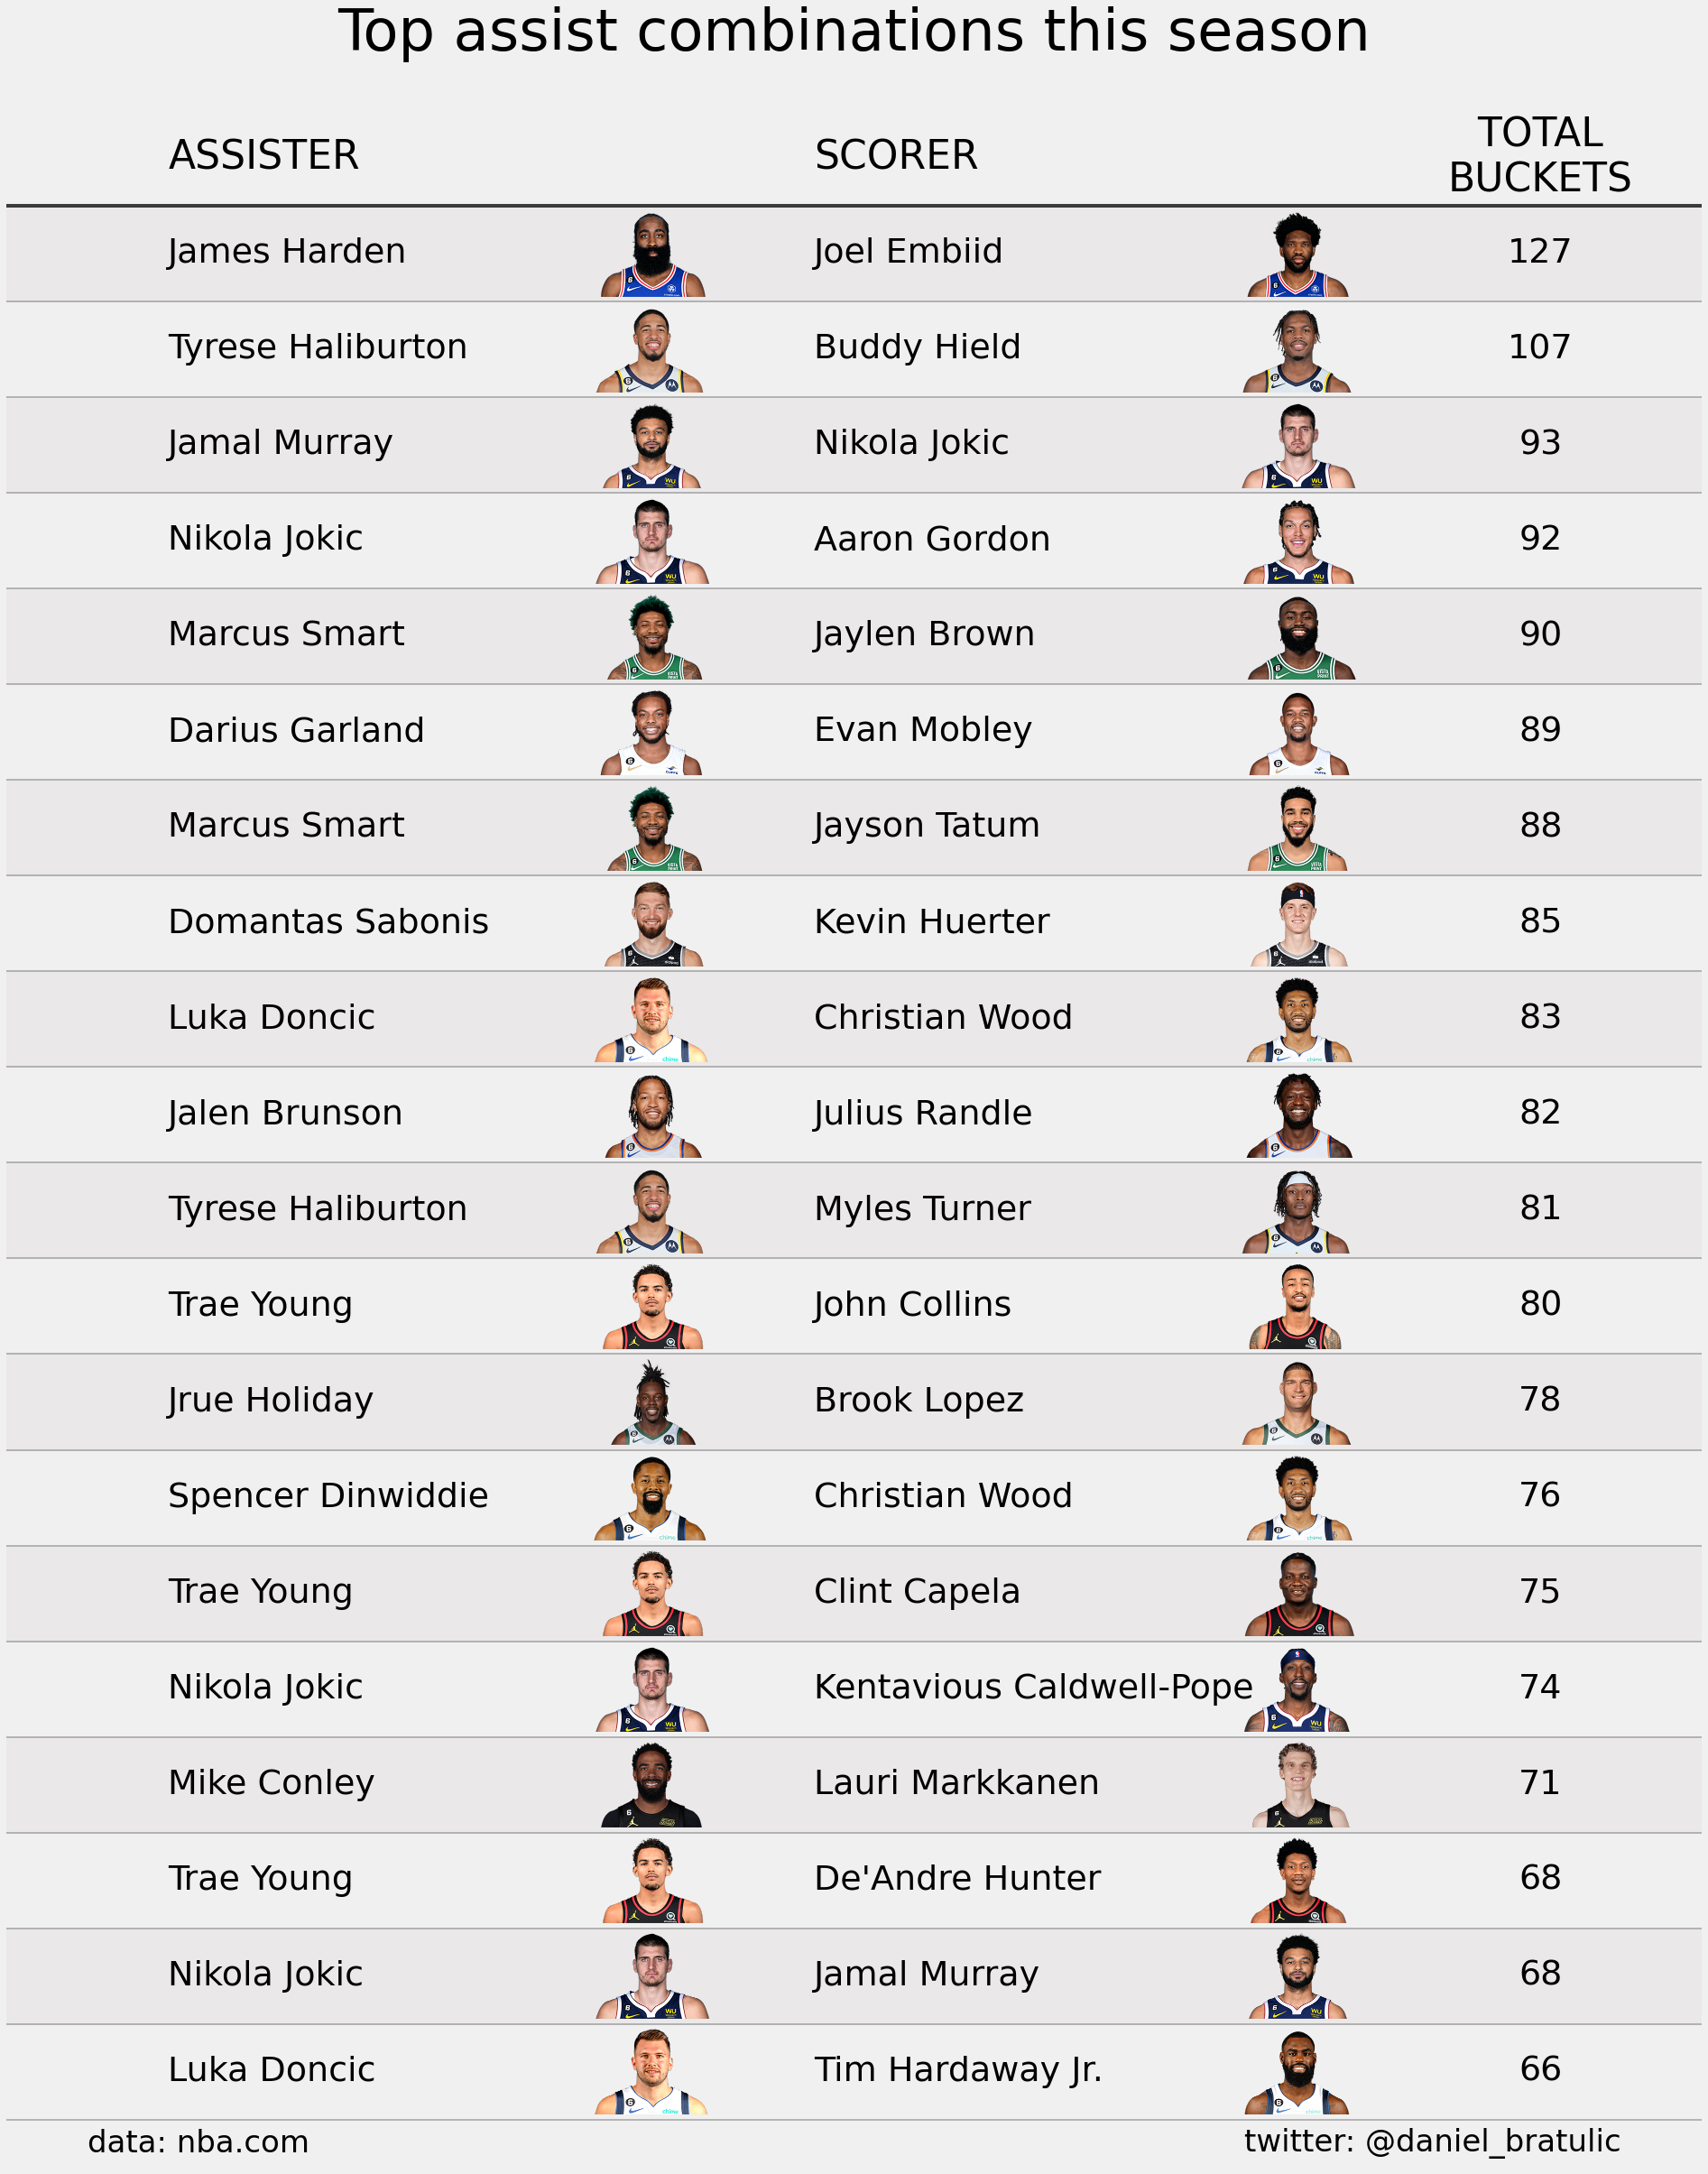

In [89]:
fig, ax = plt.subplots(figsize=(30, 40))
font_size = 38
font_title = 44
top = len(top_assists)
#top = 10


for i in range(top):
    item = top_assists.iloc[i]
    y_coord = top - i - 1
    if i % 2 == 1:
        color = '#EAE8E8'
        rect = Rectangle((-4.5, y_coord + 0.5), width=15, height=1, fill=True, color=color)
        ax.add_patch(rect)
    ax.axhline(y=y_coord-0.5, xmin=-0.25, xmax=10, color='#A0A0A0', alpha=0.75, lw=2)
    ab = AnnotationBbox(get_player_img(item.PLAYER2_ID, 0.5), (0.4, y_coord), frameon=False)
    ax.add_artist(ab)
    ax.text(x=0.1, y=y_coord, ha='left', va='center', s=item.PLAYER2_NAME, size=font_size)
    
    ab = AnnotationBbox(get_player_img(item.PLAYER1_ID, 0.5), (0.8, y_coord), frameon=False)
    ax.add_artist(ab)
    ax.text(x=0.5, y=y_coord, ha='left', va='center', s=item.PLAYER1_NAME, size=font_size)
    ax.text(x=0.95, y=y_coord, ha='center', va='center', s=f"{item.COUNT}", size=font_size)
    #ax.text(x=2.2, y=y_coord, ha='center', va='center', s=f"{item.OPP_WIDE_OPEN_FG3_PCT:.2f}%", size=font_size)
    #ax.text(x=2.7, y=y_coord, ha='center', va='center', s=f"{item.DIFF:.2f}%", size=font_size)
    

    #ax.imshow(player_imgs[item.PLAYER_ID], extent=(0, 0.3, y_coord-0.5,y_coord + 0.5), aspect='auto', zorder=1)
    #ax.imshow(team_imgs[item.TEAM_ID], extent=(0.27, 0.38, y_coord-0.5,y_coord + 0.5), aspect='auto', zorder=1)
    
    
    #y_img_start = y_coord-0.5 + (1 - 0.730769232) / 2
    #ax.imshow(img, extent=(0, 1.36, y_img_start-0.5, y_img_start + 0.1), aspect='auto')
    #ax.imshow(img, extent=(0, 260, 0, 190), aspect=260/190)
    
ax.text(x=0.1, y=top, s='ASSISTER', ha='left', va='center', size=font_title)
ax.text(x=0.5, y=top, ha='left', va='center', s="SCORER", size=font_title)
ax.text(x=0.95, y=top, ha='center', va='center', s="TOTAL\nBUCKETS", size=font_title)
#ax.text(x=2.7, y=top, ha='center', va='center', s="DIFF", size=font_title)

ax.text(x=1.0, y=-0.75, s='twitter: @daniel_bratulic', ha='right', va='center', size=34)
ax.text(x=0.05, y=-0.75, s='data: nba.com', ha='left', va='center', size=34)
ax.axhline(y=top-0.5, xmin=-0.25, xmax=10, color='black', alpha=0.75, lw=4)
ax.set_title("Top assist combinations this season", size=64)
    
ax.set_ylim(bottom=-1, top=top+1)
ax.set_xlim(left=-0, right=1.05)
ax.grid(False)
ax.set_frame_on(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.savefig('table_assists_all.png', dpi=120, bbox_inches='tight')